In [1]:
import flopy
import flopy.mf6 as mf6
import flopy.plot as fplt

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

## Model Domain Properties

This notebook is in the `notebooks/` folder of the `peterson-model/` directory.

The simulations input files will be stored in the `input-files/` directory. To access the files in that folder, we have to specify that our workspace is one level back (denoted by the `../`). Our relative file path (from current location to target location) `../input-files/`. 
d
The name for our simulation is `'peterson'`. We will have a `GWF` model named `'peterson-flow'`, and a `GWT` model named `'peterson-tran'`. As of right now, we only need to name the simulation.

In [2]:
workspace = '../input-files/'
sim_name = 'peterson'

Now we can define the model domain specs. We have a 20 meter grid spacing in the x- and y-directions with 972 rows and 700 columns.

Our model has one layer, and the start date of this simulation is January 1, 1970. There are 446 stress periods in the simulation starting at this date, with a varying number of days per stress period.

In [3]:
nrow = 972    # Number of rows in domain
ncol = 700    # Number of columns in domain
dr = dc = 20  # Equal spacing for x- and y-cells
nlay = 1      # single layer model

start_date_time = '1970-01-01'  # Start date of model
nper = 446                      # number of stress perdiods

We know location of the lower-left corner in space, which is given in the UTM 13N coordinates below. 

Our grid is also rotated 30$^{\circ}$ counter clockwise, so we will define the rotation as 30$^{\circ}$.

In [4]:
# Geolocation of model grid
rot = 30
xorigin = 525532.4922815983
yorigin = 4276158.318078171

The top and bottom elevations of our aquifer layer are stored in DAT files and can be read in with `np.loadtxt()`.

The paths to these files can be passed to Flopy directly, but it is often helpful to visualize these before defining the model so that we can see if things look right.

The file convention in this repository is as follows: notebooks are in the `notebooks/` directory. All simulation input files will be in the `input-files/` directory. Inside the `input-files/` folder, we have the `data-files/`, `flow-files`, and `transport-files` folders. All data files that will be passed to the simulation and models are stored in the `data-files` folder, with a 3 or 4 letter key at the beginning. 
- If the file begins with `dis-`: it is used to set up to model grid itself.
- If the file begins with `tdis-`: is is for time-discretization setup.
- If the file begins with `flow-`: it is a reference file for the GWF model.
- If the file begins with `tran-`: it is a reference file for the GWT model.

In [5]:
top_elev = np.loadtxt('../input-files/data-files/dis-top-elev.dat')          # Top elevation of layer
bedrock_elev = np.loadtxt('../input-files/data-files/dis-bedrock-elev.dat')  # Bottom elevation of layer
idomain = np.loadtxt('../input-files/data-files/dis-idomain.dat')            # Boolean array of active/inactive cells

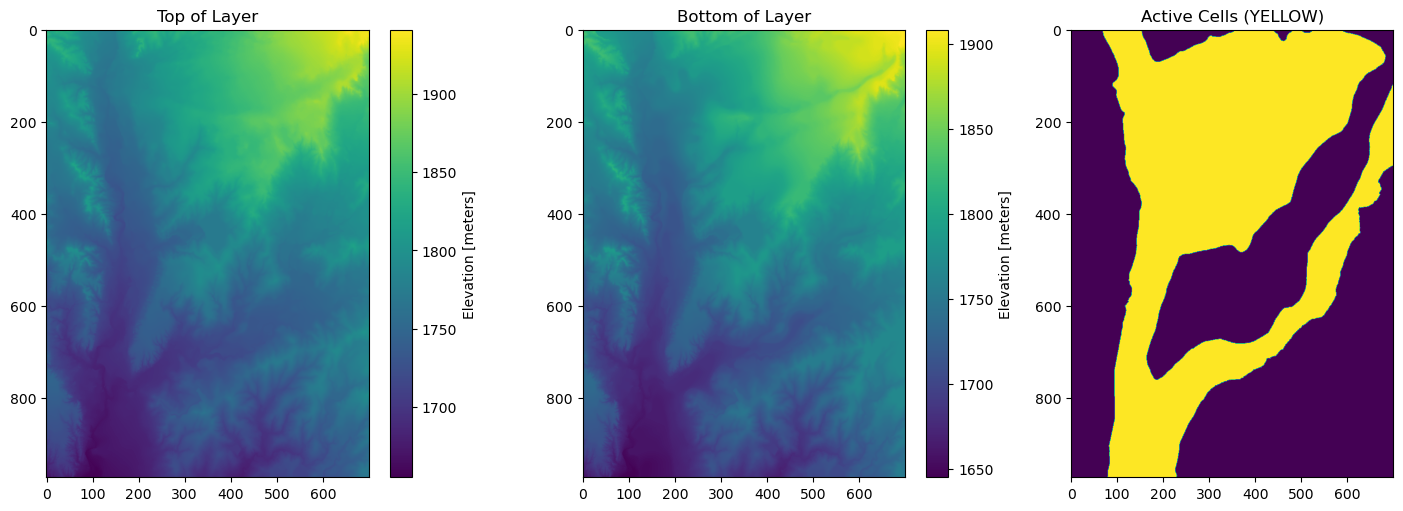

In [6]:
fig, axs = plt.subplots(ncols=3, layout='constrained', figsize=(15,5))
ax1, ax2, ax3 = axs

cs1 = ax1.imshow(top_elev)
fig.colorbar(cs1, ax=ax1, label='Elevation [meters]')
ax1.set_title('Top of Layer')

cs2 = ax2.imshow(bedrock_elev)
fig.colorbar(cs2, ax=ax2, label='Elevation [meters]')
ax2.set_title('Bottom of Layer')

ax3.imshow(idomain)
ax3.set_title('Active Cells (YELLOW)')

plt.show()

# Create Simulation

Using the function `flopy.mf6.MFSimulation()`, we will create the simulation for the MODFLOW 6 to run.

Using the `sim_name` variable we defined above, we pass that to `sim_name`. The location of the mf6 executable file is passed manually to the simulation. Beacause it is highly advised not to copy and paste the executable from its original directory, we are specifying te relative path to the executable file. The version used is mf6, and our `workspace` for all of the model input and output files is passed to `sim_ws`

In [7]:
# Create the Flopy simulation object
sim = mf6.MFSimulation(
    sim_name=sim_name, 
    exe_name="../../mf6/bin/mf6.exe", 
    version="mf6", 
    sim_ws=workspace
)

## Create Time Discretization object

The time discretization package specifies the time stepping for each stress period in the model. In our simulation, we have `446 stress periods`, and for the first ~100 stress periods we have a variable time stepping. After that, the stress periods are one month until the end of the simulation. 

There is an excel file with the number of days in each stress period. We will read this using pandas and create the perioddata variable, which is structured `[(period length, number of timesteps, TS multiplier), ...]`. The length of this list must equal the number of stress periods, and each list entry defines the number of days in that stress period.

In [8]:
# Read in time stepping excel files
time_steps = pd.read_csv('../input-files/data-files/tdis-timesteps.csv')

# Pull timesteps to numpy array. Omit last value that states "END MODEL"
time_steps = time_steps['time step [days]'].values[:-1]

# Create perioddata object
perioddata = [(float(t), 1, 1.0) for t in time_steps]
perioddata[0]

(59.0, 1, 1.0)

From the output of the previous cell, we can see that for the first stress period, there are 59 days covered, 1 timestep, and a multiplier of 1. Let's make sure that the period data list we created has the correct number of stress periods before we define the TDIS package:

In [9]:
assert len(perioddata) == nper, 'Period data does not match number of stress periods'

Since we didn't get an error message, we are ready to set up the TDIS package

In [10]:
# Create the temporal discretization object
tdis = mf6.ModflowTdis(
    sim, 
    pname="tdis", 
    time_units="DAYS", 
    nper=nper, 
    perioddata=perioddata
)

# Create Groundwater Flow Model

Now that our simulation is all set up, we can now make the models to run inside the simulation. First, we will make the groundwater flow model, `gwf`. We have many different DAT files containing important flow parameters for our model domain, like hydraulic conductivity (k), recharge multipliers (defining how much precipiation reaches the aquifer), initial head, specific storage, and specific yield.

## Load in DAT files 

Let's load in the DAT files for the flow model and see what they look like:

In [11]:
initial_head = np.loadtxt('../input-files/data-files/flow-initial-head.dat')
k_field = np.loadtxt('../input-files/data-files/flow-kfield.dat')
ss = np.loadtxt('../input-files/data-files/flow-spec-storage.dat')
sy = np.loadtxt('../input-files/data-files/flow-spec-yield.dat')
rch_multipliers = np.loadtxt('../input-files/data-files/flow-recharge-mult.dat')

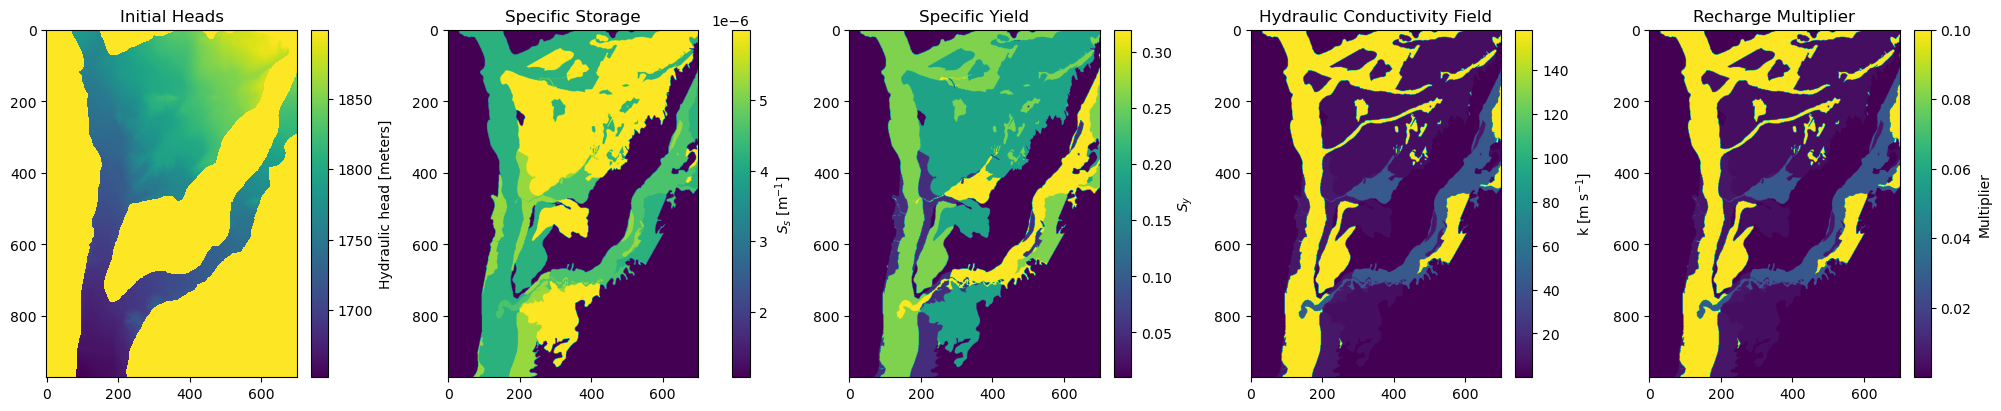

In [12]:
fig, axs = plt.subplots(ncols=5, layout='constrained', figsize=(20, 4))
ax1, ax2, ax3, ax4, ax5 = axs

vmax = initial_head[initial_head != 1e30].max()  # grab max head from the flow-cells (noflow = 1e30)
cs1 = ax1.imshow(initial_head, vmax=vmax)
fig.colorbar(cs1, ax=ax1, label='Hydraulic head [meters]')
ax1.set_title('Initial Heads')

cs2 = ax2.imshow(ss)
fig.colorbar(cs2, ax=ax2, label='$S_s$ [m$^{-1}$]')
ax2.set_title('Specific Storage')

cs3 = ax3.imshow(sy)
fig.colorbar(cs3, ax=ax3, label='$S_y$')
ax3.set_title('Specific Yield')

cs4 = ax4.imshow(k_field)
fig.colorbar(cs4, ax=ax4, label='k [m s$^{-1}$]')  # Check units - might need to move to m/day
ax4.set_title('Hydraulic Conductivity Field')

cs5 = ax5.imshow(rch_multipliers)
fig.colorbar(cs5, ax=ax5, label='Multiplier')
ax5.set_title('Recharge Multiplier')

plt.show()

In the initial heads plot, the bright yellow cells correspond with the no flow cells from the idomain plot. In modflow, no flow values are specified at `1e30`.

The Hydraulic Conductivity and Recharge multiplier fields looks very similar, which is by deisgn. The amount of recharge into the aquifer has been defined based on the hydraulic conductivity of the soil in that area. 

## Initialize GWF object

Now that we have an idea of what the parameters in this model domain look like, we can initialize and create the model. It will have the name `'peterson_flow'`, and all the files will be stored in the `flow-files/` folder of the `input-files/` directory.

In [13]:
flow_name = 'peterson_flow'

# Create the Flopy groundwater flow (gwf) model object
model_nam_file = f"{flow_name}.nam"
gwf = mf6.ModflowGwf(
    sim, 
    modelname=flow_name,
    model_nam_file=model_nam_file,
)

## Create Iterative Model Solver

Because we are using two different models, a flow and a transport model, we need to specify two different iterative model solvers and register them with each model. 

In [14]:
# IMS package for the GWF model
ims_gwf = mf6.ModflowIms(
    sim,
    pname='ims_gwf',
    filename='peterson_flow.ims',
    complexity='COMPLEX',
    linear_acceleration='BICGSTAB',
    outer_maximum=100,
    inner_maximum=500,
    inner_dvclose=0.1,
    outer_dvclose=0.1,
    rcloserecord=8460, 
    no_ptcrecord='FIRST'
)
sim.register_ims_package(ims_gwf, [flow_name])  # Assign ims_gwf to the GWF model

## Create Groundwater Model Domain Discretization

Now we get to use the parameters we plotted above to make the model domain. 

Since we have a ton of files, we must specify the relative paths to each of these DAT files

In [15]:
dis = mf6.ModflowGwfdis(
    gwf,
    pname='dis_gwf',
    length_units='METERS',
    nlay=nlay,
    ncol=ncol,
    nrow=nrow,
    delr=dr,
    delc=dc,
    top='data-files/dis-top-elev.dat',
    botm='data-files/dis-bedrock-elev.dat',
    idomain='data-files/dis-idomain.dat',
    xorigin=xorigin,
    yorigin=yorigin,
    angrot=rot
)

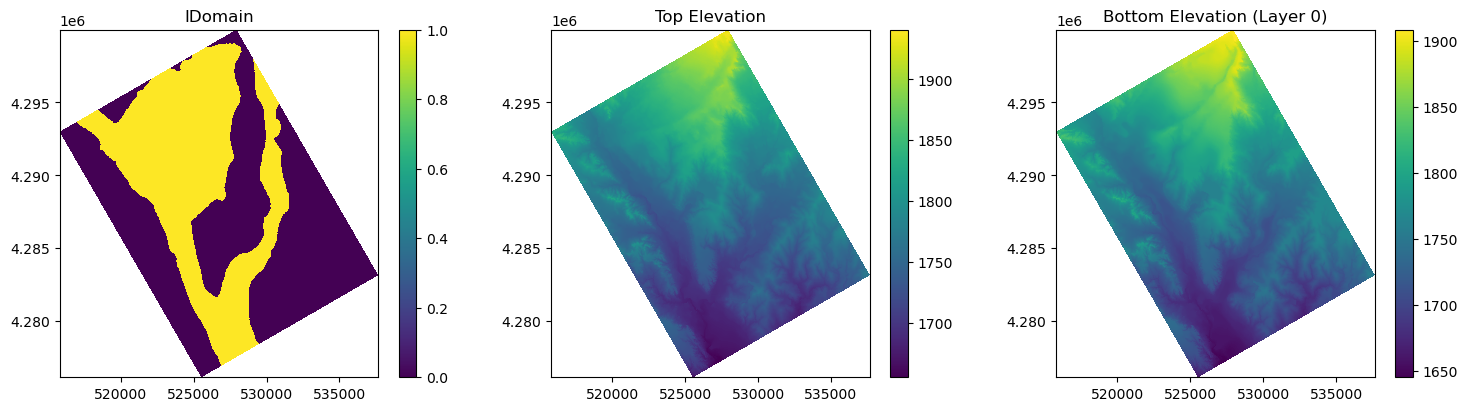

In [16]:
# Create a single figure with subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 4), layout='constrained')  # 1 row, 3 columns
ax1, ax2, ax3 = axs

# Create a PlotMapView object for each subplot
pmv_idomain = fplt.PlotMapView(model=gwf, ax=ax1)
cs1 = pmv_idomain.plot_array(dis.idomain.array)  # Plot idomain
fig.colorbar(cs1, ax=ax1)
ax1.set_title("IDomain")

pmv_top = fplt.PlotMapView(model=gwf, ax=ax2)
cs2 = pmv_top.plot_array(dis.top.array)  # Plot top elevations
fig.colorbar(cs2, ax=ax2)
ax2.set_title("Top Elevation")

pmv_botm = fplt.PlotMapView(model=gwf, ax=ax3)
cs3 = pmv_botm.plot_array(dis.botm.array[0])  # Plot bottom elevation for layer 0
fig.colorbar(cs3, ax=ax3)
ax3.set_title("Bottom Elevation (Layer 0)")

for ax in axs:
    ax.set_aspect('equal')
# Adjust layout for clarity
plt.show()

Here is the active domain (in yellow), and the elevation of the top and bottom of the layer. As you can see, the axis have been adjusted by flopy to plot at the real-world location with a 30$^{\circ}$ counter-clockwise rotation.

Using the package `cartopy`, you can set a map background to show where the model domain is in the world. That will be shown in a later notebook

## Create Initial Conditions package

In [17]:
# Initial conditions package
ic = mf6.ModflowGwfic(
    gwf, 
    pname='ic_gwf', 
    strt='data-files/flow-initial-head.dat'
)

## Create Node Propertry Flow package

Pass k-field from before using the file pathway. There are several k values, and only 1 DAT file. 

We are passing k, the x-direction hydraulic conductivity, and k33, the vertical hydraulic conductivity. The vertical k, k33, is 0.75 times the x-direction k. 

Since we are passing a file, this means we need to create a dictionary for the k-values to speficy the factor.

In [18]:
k = {'filename':'data-files/flow-kfield.dat', 'factor':1.0}
k33 = {'filename':'data-files/flow-kfield.dat', 'factor':0.75}

In [19]:
# Create the node property flow package
npf = mf6.ModflowGwfnpf(
    gwf, 
    pname='npf', 
    icelltype=0,  # Confined aquifer
    k=k, 
    k33=k33,
    save_flows=True
)

Let's plot the different tensor directions to ensure they were added to the file correctly

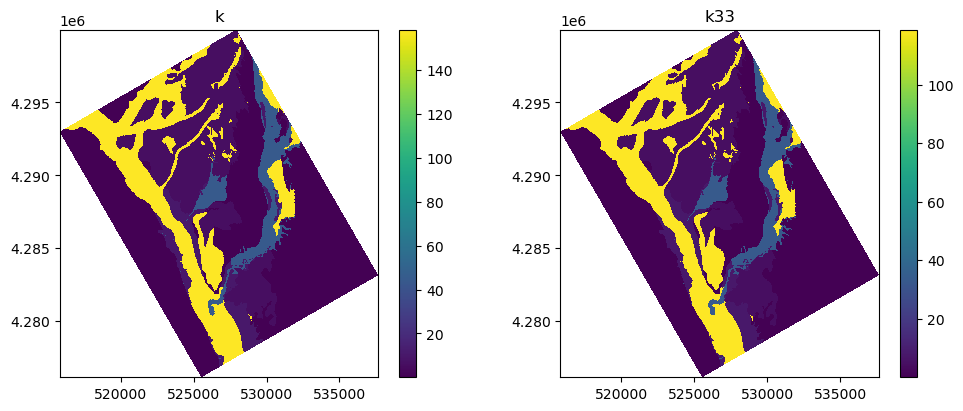

In [20]:
# Create a single figure with subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 4), layout='constrained')  # 1 row, 3 columns
ax1, ax2 = axs

# Create a PlotMapView object for each subplot
pmv_idomain = fplt.PlotMapView(model=gwf, ax=ax1)
cs1 = pmv_idomain.plot_array(npf.k.array)  # Plot idomain
fig.colorbar(cs1, ax=ax1)
ax1.set_title("k")

pmv_top = fplt.PlotMapView(model=gwf, ax=ax2)
cs2 = pmv_top.plot_array(npf.k33.array)  # Plot top elevations
fig.colorbar(cs2, ax=ax2)
ax2.set_title("k33")

for ax in axs:
    ax.set_aspect('equal')
# Adjust layout for clarity
plt.show()

## Create River packages

We have CSV files containing the cellid, stage (river head), cond (hydraulic conductance of the river bed), rbot (bottom of river elevation), and boundname.

To use geospatial data to construct the river package, refer to this [Hatari Labs blog](https://hatarilabs.com/ih-en/how-to-create-a-modflow-6-model-from-geospatial-data-with-python-and-flopy-tutorial).

In [21]:
import ast

# Read in two river csvs
riv_ftn = pd.read_csv('../input-files/data-files/flow-riv-fountain.csv', index_col='Period')
riv_sndjim = pd.read_csv('../input-files/data-files/flow-riv-sandjimmy.csv', index_col='Period')

# Concatenate two dataframes
riv_loc = pd.concat([riv_ftn, riv_sndjim])

# Cell id loads in as STR, need it as a TUPLE. This fixes that issue
riv_loc['CELLID'] = riv_loc['CELLID'].apply(ast.literal_eval)

riv_loc.head()

,CELLID,STAGE,COND,RBOT,BOUNDNAME
Period,,,,,
1,"(0, 421, 171)",1717.8,1810.0,1717.0,fountain
1,"(0, 422, 171)",1717.8,10996.8,1717.0,fountain
1,"(0, 423, 171)",1717.8,2651.6,1717.0,fountain
1,"(0, 420, 170)",1717.8,152.1,1717.0,fountain
1,"(0, 421, 170)",1718.8,13435.4,1718.0,fountain


Here, we can see that the file defines the cellid, stage (head), conductance of the riverbed, bottom elevation, and name of the river it belongs to for each stress period. 

In [22]:
# Create stress period data
river_spd = {}
for i in range(342):
    # Initialize empty list for SP
    river_spd[i] = []
    stress_period = riv_loc.loc[i+1, ['CELLID', 'STAGE', 'COND', 'RBOT']]
    
    # Iterate through all cells for SP
    for j, cell in stress_period.iterrows():
        # Send sell to list
        row = cell.tolist()
        # Ensure in float
        cleaned_row = [float(x) if isinstance(x, (np.floating, np.float64)) else x for x in row]

        river_spd[i].append(cleaned_row)

# Grab maximum number of river cells in any period for maxbound
max_len = max([len(spd) for spd in river_spd.values()])

In [23]:
riv = mf6.ModflowGwfriv(
    gwf, 
    pname='riv',
    stress_period_data=river_spd, 
    maxbound=max_len
)

## Observation Package

In the model, we have 166 individual observation wells. These can help determine how well the model is fitting real world data. It also helps with the calibration of the model. 

This process is rather nasty as you have to take the geolocated wells and find which cell they fall into. Since our domain is rotated, this process becomed even more difficult. 

We have a CSV file with each of the well names, their easting and northings, and their cellids. We will add them to the OBS package here:

In [24]:
obs_wells = pd.read_csv('../input-files/data-files/flow-obs-wells.csv')

# Cell id loads in as STR, need it as a TUPLE. This fixes that issue
obs_wells['cell'] = obs_wells['cell'].apply(ast.literal_eval)

obs_wells.head()

,well_name,easting,northing,cell
0,FOUNTAIN NO.1,525770.414425,4.282051e+06,"(0, 722, 157)"
1,SC01406518ACD T02-MW006,525372.858740,4.298203e+06,"(0, 13, 544)"
2,SC01406518CAA MW 1-1,524954.546222,4.297973e+06,"(0, 12, 520)"
3,SC01406519ABD T04-MW004,525403.486332,4.296995e+06,"(0, 66, 515)"
4,SC01406519BBB T01-MW002,524340.139607,4.297363e+06,"(0, 23, 478)"


In [25]:
obs_data = []
for _, well in obs_wells.iterrows():
    cell = well['cell']

    obs_data.append((f"{well['well_name']}", "HEAD", cell))

In [26]:
# Create observation package
obs_package = mf6.ModflowUtlobs(
    gwf,
    pname="obs",
    digits=10,
    print_input=True,
    continuous={"../output-files/head_obs.csv": obs_data},
)

## Create Well Package

In [27]:
pumping_wells = pd.read_csv('../input-files/data-files/flow-pumping-wells.csv')

In [28]:
stress_period_data = {}
for i in range(111, 447):
    # Grab data for stress period
    sp_df = pumping_wells[pumping_wells['Period'] == i]
    
    sp = []
    for _, well in sp_df.iterrows():
        well_data = [(int(well.Layer), int(well.Row), int(well.Column)), int(well.PumpingRate)]
        sp.append(well_data)

    stress_period_data[i] = sp

In [29]:
auto_flow_reduce = 0.1

wel = mf6.ModflowGwfwel(
    gwf,
    pname='wel',
    auto_flow_reduce=auto_flow_reduce,
    maxbound=39,
    stress_period_data=stress_period_data
)

## Create Constant Head Package

CHB at model boundary intersection w/ flow areas

In [30]:
# Create the constant head package.
# List information is created a bit differently for
# MODFLOW 6 than for other MODFLOW versions.  The
# cellid (layer, row, column, for a regular grid)
# must be entered as a tuple as the first entry.
# Remember that these must be zero-based indices!
#  chd = [((layer, row, column), head), ...]
chd_rec = []

mask = idomain == 1

rows, cols = initial_head.shape
edge_indices = (
    [(0, i) for i in range(cols)] +  # Top row
    [(rows - 1, i) for i in range(cols)] +  # Bottom row
    [(i, 0) for i in range(1, rows - 1)] +  # Left column (excluding corners)
    [(i, cols - 1) for i in range(1, rows - 1)]  # Right column (excluding corners)
)

edge_indices = np.array(edge_indices)
masked_edge_indices = [tuple(idx) for idx in edge_indices if mask[tuple(idx)]]

# Extract values and indices
values = [initial_head[idx] for idx in masked_edge_indices]
boundary_heads = np.column_stack([masked_edge_indices, values])

for row, col, head in boundary_heads:
    chd_rec.append([(0, int(row), int(col)), head])

chd = mf6.ModflowGwfchd(
    gwf,
    pname='chd',
    maxbound=len(chd_rec),
    stress_period_data=chd_rec,
    save_flows=True
)

## Create Storage Properties Package

In [31]:
ss = {'filename':'data-files/flow-spec-storage.dat', 'factor':1.0}
sy = {'filename':'data-files/flow-spec-yield.dat', 'factor':1.0}

sto = mf6.ModflowGwfsto(
    gwf,
    pname='sto',
    ss=ss,
    sy=sy,
    iconvert=1,
    steady_state={0: True},  # Steady-state in stress period 0
    transient={1: True}      # Transient from stress period 1 onward
)

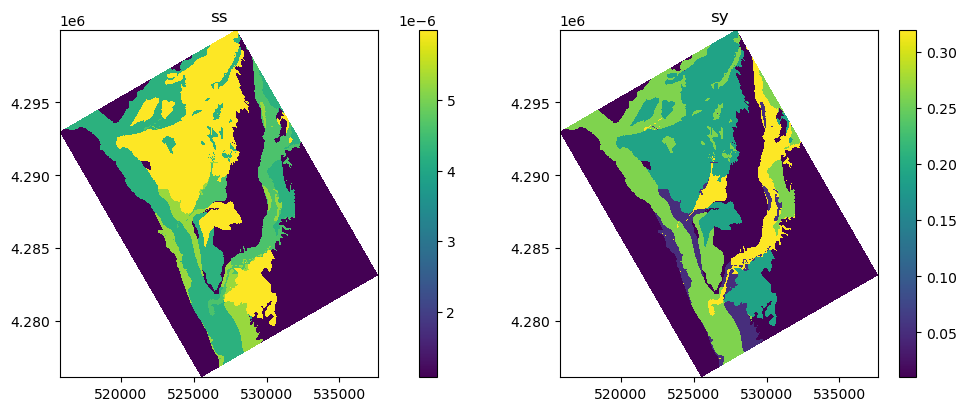

In [32]:
# Create a single figure with subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 4), layout='constrained')  # 1 row, 3 columns
ax1, ax2 = axs

# Create a PlotMapView object for each subplot
pmv_idomain = fplt.PlotMapView(model=gwf, ax=ax1)
cs1 = pmv_idomain.plot_array(sto.ss.array)  # Plot idomain
fig.colorbar(cs1, ax=ax1)
ax1.set_title("ss")

pmv_top = fplt.PlotMapView(model=gwf, ax=ax2)
cs2 = pmv_top.plot_array(sto.sy.array)  # Plot top elevations
fig.colorbar(cs2, ax=ax2)
ax2.set_title("sy")

for ax in axs:
    ax.set_aspect('equal')
# Adjust layout for clarity
plt.show()

## Create Recharge Package

This one.. this one's a PAIN.

This is built following the Flopy [ReadtheDocs](https://flopy.readthedocs.io/en/3.4.3/Notebooks/mf6_data_tutorial04.html). For more in depth understanding, see that page.

To do recharge multipliers, it's much easier to use the RCHA package, which is the advanced recharge. This package works best with the time array series. Let's build that package here.

First we need to load in the precipitation data. This data is the amount of rainfall in centimeters recorded over that given day, and is stored in a CSV file. 

In [33]:
precip = pd.read_csv('../input-files/data-files/flow-precipitation.csv')
precip

,Time [days],Precip [cm]
0,1,2.0000
1,2,0.0000
2,3,0.0000
3,4,0.0000
4,5,0.0508
...,...,...
18257,18258,0.0254
18258,18259,0.0000
18259,18260,0.0000
18260,18261,0.0000


There are 18,262 days in the simulation since January 1, 1970. We have decided that a stepwise interpolation would be the best way to approach the time series to not add data where we don't have any. Because of this, we are able to eliminate a lot of points we would pass to the TAS. 

We can remove any consecutive days that have the same precip (back to back 0.0 will be represented by a 0.0 on the first day).

In [34]:
precip_new = precip.loc[precip['Precip [cm]'].diff() != 0]
precip_new

,Time [days],Precip [cm]
0,1,2.0000
1,2,0.0000
4,5,0.0508
5,6,0.0000
44,45,0.1270
...,...,...
18247,18248,0.0000
18250,18251,2.0000
18251,18252,0.0000
18257,18258,0.0254


Now there are only 6,960 days. Reducing this time series also reduces the computational overhead and redundancy.

In doing this, however, we learned through trial and error that MODFLOW requires the final day to have a value. Even though, in our dataset, the precip from day 18,258 to 18,262 does not change, we have to specify day 18,262 in the TAS.

In [35]:
# Add precip data from final day of simulation
precip_new.loc[len(precip)-1, :] = precip.loc[len(precip)-1, :]
precip_new

C:\Users\jackp\AppData\Local\Temp\ipykernel_28420\1947551415.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  precip_new.loc[len(precip)-1, :] = precip.loc[len(precip)-1, :]


,Time [days],Precip [cm]
0,1.0,2.0000
1,2.0,0.0000
4,5.0,0.0508
5,6.0,0.0000
44,45.0,0.1270
...,...,...
18250,18251.0,2.0000
18251,18252.0,0.0000
18257,18258.0,0.0254
18258,18259.0,0.0000


Now that we have the precipitation data loaded in, we can create the time array. This is a dictionary with entries {day:precipitation}. 

Once we have this dictionary, we can create the dictionary that will initialize the TAS array package. See the `flopy.mf6.ModflowUtltas` documentation to find the relevant variable for your model. The parameters we want to define in this dictionary are the following:
- `filename`: name of the TAS file
- `pname`: name of the TAS package
- `tas_array`: this is the timeseries dictionary created from the dataframe
- `time_series_namerecord`: name of the time series to be referenced in the RCHA package
- `interpolation_methodrecord`: tells MODFLOW how to interpolate the data

In [36]:
# time series array
tas_array = dict(zip(precip_new['Time [days]'], precip_new['Precip [cm]']/100))

# name of time series to reference in RCHA package
time_series_name = 'rch_timeseries'

# dictionary specifying TAS package parameters
timearrayseries = {
    'filename':'peterson_flow.tas',
    'tas_array':tas_array,
    'time_series_namerecord':time_series_name,
    'interpolation_methodrecord':'STEPWISE',
}

Now that we have built the time series array, we can build the RCHA package.

For each stress period, we have to specify that we are going to use a TAS. We will create a dictionary with an entry for each period. The dictionary set up is as such:
- `{0:'TIMEARRAYSERIES <time series name>', 1:'TIMEARRAYSERIES <time series name>', ..., nper:<time series name>}`

Since we are using a multiplier, we have to use an auxiliary variable. The setup is mostly the same. For each stress period, set the path to the multiplier DAT file.
- `{0:'<file pathpath to file>', 1:<file path>, ..., nper:<file path>}`

In [37]:
# intialize stress period recharge and auxiliary arrays
recharge_array = {}
aux_array = {}

for i in range(nper):
    recharge_array[i] = f'TIMEARRAYSERIES {time_series_name}'
    aux_array[i] = "data-files/flow-recharge-mult-new.dat"

Now that we have built the stress period arrays for both the auxiliary variable and the recharge values, we can build the RCHA package. We will pass an auxiliary variable that tells modflow to look for the file path. You can pass multiple auxiliary variables, so you have to tell modflow which of these auxiliary variables contains multiplier data. Since we only have one auxiliary variable, `auxiliary` and `auxmultname` will be the same.

The timearrayseries dictionary we created a few cells above will get passed to the `timearrayseries` parameters, and flopy will create both the RCHA and the TAS packages at once

In [38]:
rcha = mf6.ModflowGwfrcha(
    gwf,
    pname='rcha',
    auxiliary='rch_mult',
    auxmultname='rch_mult',
    recharge=recharge_array,
    aux=aux_array,
    timearrayseries=timearrayseries
)

## Create Output Control package

In [39]:
# Create the output control package
headfile = f"../output-files/{flow_name}.hds"
head_filerecord = [headfile]
budgetfile = f"../output-files/{flow_name}.cbb"
budget_filerecord = [budgetfile]
saverecord = [("HEAD", "ALL"), ("BUDGET", "ALL")]

oc = mf6.ModflowGwfoc(
    gwf,
    pname="oc_gwf",
    filename='peterson_flow.oc',
    saverecord=saverecord,
    head_filerecord=head_filerecord,
    budget_filerecord=budget_filerecord,
)

# Write Simulation

Now that everything's been initialized, we can write the simulation. This will write all the flow model input files we have created up to this point

In [40]:
sim.write_simulation()

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package ims_gwf...
  writing model peterson_flow...
    writing model name file...
    writing package dis_gwf...
    writing package ic_gwf...
    writing package npf...
    writing package riv...
    writing package obs...
    writing package wel_0...
    writing package chd...
    writing package sto...
    writing package rcha...
    writing package tas_0...
    writing package oc_gwf...


In [42]:
## Uncommment this cell to run the flow model

success, buff = sim.run_simulation(report=True)
assert success

FloPy is using the following executable to run the model: ..\..\mf6\bin\mf6.exe
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.5.0 05/23/2024

   MODFLOW 6 compiled May 23 2024 18:06:57 with Intel(R) Fortran Intel(R) 64
   Compiler Classic for applications running on Intel(R) 64, Version 2021.7.0
                             Build 20220726_000000

This software has been approved for release by the U.S. Geological 
Survey (USGS). Although the software has been subjected to rigorous 
review, the USGS reserves the right to update the software as needed 
pursuant to further analysis and review. No warranty, expressed or 
implied, is made by the USGS or the U.S. Government as to the 
functionality of the software and related material nor shall the 
fact of release constitute any such warranty. Furthermore, the 
software is released on condition that neither the USGS nor the U.S. 
Government s